# Executive Summary

This notebook contains:
- **Core DeFi lending mechanics**: utilization curves, interest accrual, multi-asset health factors, liquidation logic.
- **Book risk management**: buffer policy, margin/top-up sizing, liquidation prevention actions, stress testing.
- **AMM execution mechanics**: constant-product slippage (explicit), and why liquidation outcomes can worsen under thin liquidity.
- **Smart contract triage** (lightweight): how to read Solidity *at a basic level* and flag common high-severity patterns before deploying capital.
- **RWA bridge (conceptual)**: how off-chain cashflows map to on-chain tokens (SPV + enforceability), plus a toy valuation/risk view. 

The notebook demonstrates:
- continuous monitoring of **Health Factors** and stress testing, plus governance/policy limits
- DeFi mechanics: **utilization curves**, **liquidation logic**, and **AMM** execution
- awareness of **smart contract vulnerabilities** (preferred)
- awareness of **RWA** bridging mechanisms (preferred)
- managing a **book**: margin management and liquidation prevention under volatility

In [1]:
# 1) Imports and setup
import numpy as np 
np.random.seed(7)

import pandas as pd
pd.set_option("display.float_format", "{:,.4f}".format)

import matplotlib.pyplot as plt
def set_mpl_defaults():
    # Use matplotlib defaults; do not set explicit colors.
    plt.rcParams.update({
        "figure.figsize": (15, 3),
        "axes.grid": False,
        "grid.alpha": 0.3,
        "axes.titlesize": 12,
        "axes.labelsize": 11,
        "legend.frameon": False,
    })
set_mpl_defaults()

from dataclasses import dataclass

## 2) DeFi Credit Risk

DeFi credit risk is governed by a solvency ratio called the **Health Factor** ($HF$). Liquidation eligibility is determined mechanically when $HF$ falls below 1, so $HF$ is the foundation for continuous monitoring and control triggers.

Let $q_{k,c}$ be collateral token quantities, $D_{k,d}(t)$ be debt token quantities, and $P_c(t), P_d(t)$ be oracle prices in USD per token.

Note, $P_c(t)$ and $P_d(t)$ denote the **oracle prices actually used by the protocol** for solvency checks and liquidation eligibility. These may be based on a time-weighted average price (TWAP) rather than instantaneous spot.
Over $[t_0,t_1]$, it is defined as:
$$
P_{\text{TWAP}}=\frac{1}{t_1-t_0}\int_{t_0}^{t_1} p(u)\,du
\quad \text{or} \quad
P_{\text{TWAP}}=\frac{\sum_i p_i\,\Delta t_i}{\sum_i \Delta t_i}
$$
TWAP reduces sensitivity to brief price spikes (harder to manipulate), but it can lag during fast market moves. Since $HF_k(t)$ is computed from $P_c(t)$ and $P_d(t)$, oracle design directly affects liquidation timing and clustering.


Think of the protocol as running a continuous “can this borrower be safely kept open?” check:

- $V_{\text{coll}}^{(k)}(t)$ is the *risk-adjusted* value of what the borrower posted as collateral.
- $V_{\text{debt}}^{(k)}(t)$ is what the borrower owes (in USD terms).

Hence:
$$
    V_{\text{coll}}^{(k)}(t)=\sum_{c} q_{k,c}\,P_c(t)\,LT_c
    \quad \text{and} \quad
    V_{\text{debt}}^{(k)}(t)=\sum_{d} D_{k,d}(t)\,P_d(t)
$$
Here $LT_c$ is the liquidation threshold / collateral factor (effectively a haircut). Typically $LT_c < 1$, triggering a liquidation even when raw collateral value still exceeds debt—this buffer is designed to cover liquidation incentives and execution/slippage risk.

$$
HF_k(t)=\frac{V_{\text{coll}}^{(k)}(t)}{V_{\text{debt}}^{(k)}(t)},\qquad
\text{Regime}(HF_k)=
\begin{cases}
\text{Safe (buffered)}, & HF_k>1\\
\text{At threshold}, & HF_k=1\\
\text{Liquidatable}, & HF_k<1
\end{cases}
$$

For example, assume:
- 1 ETH collateral, oracle price $P_{\text{ETH}} = 2{,}000$
- liquidation threshold $LT_{\text{ETH}}=0.85$
- debt $D = 1{,}600$ USDC

Then:
- $V_{\text{coll}} = 1 \cdot 2{,}000 \cdot 0.85 = 1{,}700$
- $V_{\text{debt}} \approx 1{,}600$
- $HF = 1{,}700/1{,}600 = 1.0625$ (safe but close)

If ETH drops to $1{,}850$:
- $V_{\text{coll}} = 1 \cdot 1{,}850 \cdot 0.85 = 1{,}572.5$
- $HF = 1{,}572.5/1{,}600 = 0.983$ → liquidatable

For a book of accounts, we therefore monitor $HF$ because it is the **margin buffer** for each borrower.

For a lending pool (e.g., USDC), the protocol also runs a continuous “is the pool liquid enough?” check. This system-wide state is denoted as **utilization**:

$$
U(t)=\frac{B(t)}{S(t)} \in [0,1],
$$

where $S(t)$ is the total supplied liquidity (tokens available to lend) and $B(t)$ is the total borrowed amount (tokens currently lent out). Note that $HF_k(t)$ is **account-level**, while $U(t)$ is **pool-level** and affects borrow rates for all borrowers in that pool.

A practical interpretation is:

$$ 
\text{Intuition}(U)=
\begin{cases}
\text{Low utilization: ample liquidity (withdrawals easy; borrowing cheap)}, & 0 \le U < 0.5\\
\text{Moderate utilization: balanced pool conditions}, & 0.5 \le U \le U^*\\
\text{High utilization: tight liquidity (withdrawals harder; borrowing expensive)}, & U^* < U \le 1
\end{cases}
$$

where $U^*$ is the “kink” utilization defined below.

This system metric is significant for **credit risk** for two reasons:

1) As $U$ rises, protocols raise borrow rates, which increases debt growth and pushes marginal accounts toward liquidation.  
2) If suppliers want to withdraw when $U$ is high, there is little liquidity available, so the protocol must incentivize new supply via higher rates.

Most protocols implement a borrow-rate function $r_b(U)$ that increases with $U$, and increases *much faster* beyond a target utilization $U^*$ (the “kink”). A standard piecewise-linear form is:

$$
r_b(U)=
\begin{cases}
r_0 + aU, & U \le U^*\\
r_0 + aU^* + b(U-U^*), & U > U^*
\end{cases}
\qquad \text{with } b>a
$$

Borrowers’ debt grows over time according to the borrow rate. In discrete time (with $\Delta t$ in years):

$$
D(t+\Delta t)=D(t)\,(1+r_b(U)\Delta t).
$$

Holding collateral and prices fixed, higher $U$ $\Rightarrow$ higher $r_b(U)$ $\Rightarrow$ debt grows faster $\Rightarrow$ $V_{\text{debt}}$ increases $\Rightarrow$ $HF$ decreases.

A useful approximation (if prices/collateral are unchanged) is:

$$
HF_k(t+\Delta t)\approx \frac{HF_k(t)}{1+r_b(U)\Delta t}
$$

Assume a borrower has $D(t)=1{,}600$ USDC debt and we compare two utilization regimes over 30 days (rates illustrative; protocol/asset specific):

- Low utilization: $U=0.40 \Rightarrow r_b(U)\approx 6\%$ annual  
- High utilization: $U=0.92 \Rightarrow r_b(U)\approx 35\%$ annual  

Over 30 days ($\Delta t \approx 30/365$), debt increases roughly by:
- Low $U$: $1{,}600 \times 0.06 \times 30/365 \approx 7.9$ USDC  
- High $U$: $1{,}600 \times 0.35 \times 30/365 \approx 46.0$ USDC  

That incremental debt reduces $HF$ mechanically. For borderline accounts, this can be the difference between staying above the buffer (e.g., $HF_{\min}=1.10$) and entering the watchlist.

Utilization is therefore a system-wide “risk temperature” indicator. In practice you monitor:
- **Utilization level** $U(t)$ and distance to $U^*$  
- **Borrow rate** $r_b(U(t))$ (funding conditions)  
- **Borrow rate shocks** under stress (e.g., $U \to 0.95$)  
- Impact on **projected debt growth** and resulting **$HF$ drift** for the lowest-$HF$ accounts

In short: **$HF$ is the borrower’s margin buffer; $U$ is the pool’s liquidity/funding state that can erode that buffer over time.**


---
This notebook is intentionally **simple**. The results are conditional on a small set of explicit modeling assumptions (“knobs”). If we change these knobs, tail outcomes (especially shortfall) can change materially.

**Protocol / credit knobs**
- Liquidation threshold $LT$ (collateral haircut): lower $LT$ ⇒ more conservative collateral valuation.
- Liquidation bonus $\lambda$: higher $\lambda$ ⇒ liquidations are more expensive and increase shortfall risk.
- Close factor: limits how much debt can be repaid per liquidation step; smaller values can increase multi-step execution risk.

**Liquidity / execution knobs**
- AMM depth (pool reserves): lower depth ⇒ higher execution slippage for the same liquidation volume.
- Fees / routing assumptions: reduce realized proceeds vs oracle marks.

**Scenario knobs**
- Price shocks / stochastic price paths.
- Liquidity depth shocks (in real stress, liquidity is often thinner when prices fall).
- Utilization / borrow-rate regime (high $U$ increases debt growth over time and can push borderline accounts into liquidation).

---

In [2]:
@dataclass
class KinkRateModel:
    r0: float
    a: float
    b: float
    U_star: float

    def r_borrow(self, U: float) -> float:
        U = float(np.clip(U, 0.0, 1.0))
        if U <= self.U_star:
            return self.r0 + self.a * U
        return self.r0 + self.a * self.U_star + self.b * (U - self.U_star)

@dataclass
class ProtocolParams:
    LT: dict                 # per-collateral liquidation threshold
    liq_bonus: float         # liquidation bonus (in debt units, simplified)
    close_factor: float      # max fraction of a position liquidated in one liquidation
    rate_model: KinkRateModel

def accrue_debt(D: float, r: float, dt_years: float) -> float:
    return D * (1.0 + r * dt_years)

def health_factor_multi(coll_qty: dict, debt_qty: dict, prices: dict, params: ProtocolParams) -> float:
    v_coll = 0.0
    for c, q in coll_qty.items():
        v_coll += float(q) * float(prices[c]) * float(params.LT.get(c, 0.0))
    v_debt = 0.0
    for d, D in debt_qty.items():
        v_debt += float(D) * float(prices[d])
    return float("inf") if v_debt <= 0 else v_coll / v_debt

In [3]:
def twap(prices: np.ndarray, dt: float = 1.0):
    prices = np.asarray(prices, dtype=float)
    w = np.ones_like(prices) * dt
    return float(np.sum(prices * w) / np.sum(w))

# Toy: spot path with a brief spike (manipulation-like)
spot = np.array([2500, 2520, 4000, 2525, 2505], dtype=float)
P_spot_last = float(spot[-1])
P_twap = twap(spot, dt=1.0)

pd.DataFrame({"spot": spot, "note": ["normal","normal","spike","normal","normal"]}), {"last_spot": P_spot_last, "twap": P_twap}

(        spot    note
 0 2,500.0000  normal
 1 2,520.0000  normal
 2 4,000.0000   spike
 3 2,525.0000  normal
 4 2,505.0000  normal,
 {'last_spot': 2505.0, 'twap': 2810.0})

## 3) AMM execution (constant-product) — explicit slippage math (layman version)

When a protocol liquidates collateral, the collateral often has to be **sold for the debt token** (e.g., sell ETH to get USDC).  
If that sale happens on a DEX like Uniswap, the sale price is determined by an **AMM** (Automated Market Maker), not by a traditional order book. An AMM pool is like a cashier with two piles of tokens:
- one pile of token **$x$** (e.g., ETH),
- one pile of token **$y$** (e.g., USDC).

The AMM’s rule is: **the product of the two piles stays (approximately) constant**:
$
x\,y = k
$.
This rule forces the AMM to move the price **against you** when you trade:
- If you **sell ETH into the pool**, the pool ends up with **more ETH** and **less USDC**.
- Because USDC becomes scarcer in the pool, the pool makes ETH “worth less” in USDC terms.
- That is the mechanical reason you get a worse price on big trades.

Before you trade, the pool-implied price of $x$ in units of $y$ is approximately:
$
p = \frac{y}{x}
$, i.e. the spot price.
If the pool has lots of USDC relative to ETH, ETH is “expensive” in USDC; if USDC is scarce, ETH is “cheap.”

Now, suppose you sell $\Delta x$ (ETH) into the pool.
- New ETH reserve:
$
x' = x + \Delta x.
$
- Because $x'y' = k$ must hold, the new USDC reserve becomes:
$
y' = \frac{k}{x'}.
$
- The amount of USDC you actually receive is what leaves the pool:
$
\Delta y = y - y'.
$

The realized average price is:
$
p_{\text{avg}} = \frac{\Delta y}{\Delta x}.
$

This is the key quantity for liquidation outcomes, because it is the realized proceeds from selling collateral.

**This matters for liquidation risk** since:
- If $\Delta x$ is **small** relative to the pool, then $x' \approx x$ and $y' \approx y$, so $p_{\text{avg}}$ is close to the current quoted price $p$.
- If $\Delta x$ is **large** relative to the pool, then $x'$ increases a lot, which forces $y'$ down a lot, so $\Delta y$ grows slowly and the realized average price $p_{\text{avg}}$ becomes meaningfully worse than $p$.

In a way, in **stressed markets**, liquidation volume is large and liquidity is thin, so execution becomes worse and shortfalls increase.

Assume an ETH/USDC pool has:
- $x=10{,}000$ ETH and $y=25{,}000{,}000$ USDC  
So the quoted price is $p=y/x=2{,}500$ USDC per ETH.

- If you sell **100 ETH** (small trade), the realized price is close to 2,500.
- If you sell **2,000 ETH** (large trade), the realized price is much worse because the pool must conserve $k$ and USDC becomes scarce.

So when liquidations are large and liquidity is thin, the market price you actually get can be materially worse than the oracle mark.

Hence, even if an account looks barely solvent using oracle marks, the liquidation sale can realize a worse price due to AMM slippage. This is one reason why:
- liquidation thresholds use $LT_c<1$ (a buffer), and
- stress tests should include execution assumptions (liquidity depth, slippage, and liquidation volume).

In [4]:
def amm_sell_x_for_y(x: float, y: float, dx: float, fee: float = 0.0):
    # dx is amount of x sold into the pool; fee is fraction (e.g., 0.003)
    dx_eff = dx * (1.0 - fee)
    k = x * y
    x2 = x + dx_eff
    y2 = k / x2
    dy = y - y2
    p_avg = dy / dx if dx > 0 else 0.0
    p_mid_before = y / x
    p_mid_after = y2 / x2
    return {
        "dy_out": dy,
        "p_avg": p_avg,
        "p_mid_before": p_mid_before,
        "p_mid_after": p_mid_after,
        "x2": x2,
        "y2": y2,
    }

# Quick slippage illustration
x0, y0 = 10_000.0, 25_000_000.0   # e.g., 10k ETH, 25m USDC => ~2500 USDC/ETH
for dx in [10, 100, 500, 2_000, 2_500]:
    res = amm_sell_x_for_y(x0, y0, dx, fee=0.003)
    print(f"Sell {dx:>4} ETH -> receive {res['dy_out']:>12,.0f} | mid before {res['p_mid_before']:>8.2f} | USDC | avg px {res['p_avg']:>8.2f} | mid after {res['p_mid_after']:>8.2f}")

Sell   10 ETH -> receive       24,900 | mid before  2500.00 | USDC | avg px  2490.02 | mid after  2495.02
Sell  100 ETH -> receive      246,790 | mid before  2500.00 | USDC | avg px  2467.90 | mid after  2450.89
Sell  500 ETH -> receive    1,187,074 | mid before  2500.00 | USDC | avg px  2374.15 | mid after  2268.22
Sell 2000 ETH -> receive    4,156,245 | mid before  2500.00 | USDC | avg px  2078.12 | mid after  1737.85
Sell 2500 ETH -> receive    4,987,993 | mid before  2500.00 | USDC | avg px  1995.20 | mid after  1601.92


Each line shows what happens if we *sell* a given amount of ETH ($\Delta x$) into an ETH/USDC constant-product AMM. The script reports (i) how many USDC the trade returns ($\Delta y$), (ii) the pool’s quoted mid price before the trade ($p_{\text{mid before}}=y/x$), (iii) the realized average execution price $p_{\text{avg}}=\Delta y/\Delta x$, and (iv) the pool’s quoted mid price after the trade ($p_{\text{mid after}}=y'/x'$). As the sell size grows from 10 ETH to 2,500 ETH, the realized average price falls from ~2,490 to ~1,995 USDC/ETH while the post-trade quoted price falls even further (to ~1,602). This is **slippage/price impact**: large forced liquidation trades move the AMM price against the seller, reducing realized proceeds and increasing the chance of a liquidation shortfall relative to oracle marks.


## 4) Build a “book” and compute continuous risk indicators

We build a portfolio of $N$ accounts. Each account is initialized with a target $\mathrm{HF}$ and we solve for debt. This produces the key monitoring indicators:
- distribution of $\mathrm{HF}$
- watchlist (lowest $\mathrm{HF}$)
- % of book below internal buffer levels

In [5]:
# Simplified to 1 collateral (ETH) + 1 debt (USDC) for the portfolio build,
# but computed using the general multi-asset HF function.
base_prices = {"ETH": 2500.0, "USDC": 1.0}

params = ProtocolParams(
    LT={"ETH": 0.85},
    liq_bonus=0.05,
    close_factor=0.50,  # can liquidate up to 50% of debt in one event (protocol-dependent)
    rate_model=KinkRateModel(r0=0.02, a=0.10, b=0.60, U_star=0.80),
)

N = 300
collateral_eth = np.random.lognormal(mean=np.log(5.0), sigma=0.6, size=N)
target_hf = np.random.uniform(1.10, 2.50, size=N)
debt_usdc = (collateral_eth * base_prices["ETH"] * params.LT["ETH"]) / target_hf

portfolio = pd.DataFrame({
    "acct": np.arange(N),
    "collateral_ETH": collateral_eth,
    "debt_USDC": debt_usdc,
    "HF_target": target_hf
})

def hf_row(r, prices):
    return health_factor_multi({"ETH": r["collateral_ETH"]}, {"USDC": r["debt_USDC"]}, prices, params)

portfolio["HF_base"] = portfolio.apply(lambda r: hf_row(r, base_prices), axis=1)

# Construction check
max_abs_err = float((portfolio["HF_base"] - portfolio["HF_target"]).abs().max())

portfolio["HF_base"].describe(percentiles=[0.01,0.05,0.1,0.5,0.9,0.95,0.99]), {"max_abs_err": max_abs_err}

(count   300.0000
 mean      1.7842
 std       0.4140
 min       1.1003
 1%        1.1136
 5%        1.1708
 10%       1.2387
 50%       1.7538
 90%       2.3737
 95%       2.4331
 99%       2.4798
 max       2.4894
 Name: HF_base, dtype: float64,
 {'max_abs_err': 4.440892098500626e-16})

The above distribution shows how close the book is to liquidation at baseline:
- No one is liquidatable at start (all $HF>1$).
- There is a tail of weak accounts clustered near $\sim 1.10$–$1.25$; candidates for the **watchlist**, as they are the first to liquidate under price shocks or debt accrual.

In [6]:
assert max_abs_err < 1e-10, "HF construction mismatch (should match target by design)"
portfolio.sort_values("HF_base").head(12)[["acct","collateral_ETH","debt_USDC","HF_base"]]

,acct,collateral_ETH,debt_USDC,HF_base
222,222,4.3830,"8,465.2327",1.1003
258,258,4.9430,"9,540.5982",1.1010
164,164,6.6541,"12,751.1179",1.1089
128,128,8.9170,"17,015.0206",1.1136
296,296,15.0611,"28,722.0305",1.1143
212,212,7.1372,"13,534.1613",1.1206
155,155,13.9861,"26,498.2006",1.1216
110,110,4.2066,"7,965.0395",1.1223
83,83,2.8729,"5,401.4777",1.1302
165,165,9.7456,"18,177.7266",1.1393


The above table is the **watchlist**: the accounts with the **lowest baseline Health Factors** ($\mathrm{HF_{\text{base}}}$) in the book.

- Each row is one borrower account (`acct`) with its collateral posted (`collateral_ETH`), its debt outstanding (`debt_USDC`), and its baseline solvency buffer (`HF_base`).
- These are the **most fragile** positions: they sit closest to the liquidation threshold ($\mathrm{HF}=1$), with $\mathrm{HF}_{\text{base}}\approx 1.10$–$1.14$.
- Operationally, these accounts are most likely to become liquidatable under:
  - a collateral price drop (which reduces $V_{\text{coll}}$ and hence $\mathrm{HF}$), or
  - high utilization / high borrow rates (which increases debt and hence reduces $\mathrm{HF}$).

In practice, this table is used to trigger monitoring actions such as tighter alerts, top-up requests, deleveraging, or exposure caps.

### Buffer policy (liquidation prevention)

Define an internal buffer $HF_{\min}$ (e.g., 1.10). Breach rate:
$$\Pr(HF < HF_{\min})$$

A book manager uses this to set:
- alerts (e.g., $HF<1.10$)
- mandatory action thresholds (e.g., $HF<1.05$)

In [7]:
def breach_rate(prices, hf_min: float):
    hf = portfolio.apply(lambda r: hf_row(r, prices), axis=1).values
    return float((hf < hf_min).mean())

hf_min_levels = [1.05, 1.10, 1.20]
pd.DataFrame({
    "HF_min": hf_min_levels,
    "breach_rate_now": [breach_rate(base_prices, x) for x in hf_min_levels]
})

,HF_min,breach_rate_now
0,1.0500,0.0000
1,1.1000,0.0000
2,1.2000,0.0733


The table reports the fraction of the book that falls **below** an internal safety buffer $\mathrm{HF}_{\min}$. Formally:
$$
\text{breach_rate_now}=\Pr\!\left(\mathrm{HF}_{\text{base}}< \mathrm{HF}_{\min}\right)
$$
At baseline, there are no accounts below $\mathrm{HF}_{\min}=1.10$, consistent with the earlier distribution summary where $\min(\mathrm{HF}_{\text{base}})$ is slightly above 1.10. However, for $\mathrm{HF}_{\min}=1.20$, **7.33% of accounts** are below the buffer (about $0.073333 \times 300 \approx 22$ accounts).

In a way, this is a **policy/governance** view of solvency risk: increasing $\mathrm{HF}_{\min}$ makes the policy more conservative, but it increases the fraction of the book that triggers monitoring actions (alerts, top-ups, deleveraging).


## 5) Stress testing: stochastic regime + explicit shock grid + explainable trace

We do all three (because they answer different stakeholder questions):

- stochastic distribution (tail metrics, VaR/ES-style)
- explicit shock table (“what happens at -30%?”)
- single-scenario walkthrough (traceability)

This is “internal stress-testing models” and “governance standards” in practice.

In [8]:
def simulate_eth_terminal(P0: float, n_scen: int, horizon_days: int, vol_annual: float,
                          jump_prob: float = 0.0, jump_mean: float = -0.15, jump_std: float = 0.08):
    T = horizon_days / 365.0
    z = np.random.normal(size=n_scen)
    P = P0 * np.exp((-0.5 * vol_annual**2) * T + vol_annual * np.sqrt(T) * z)
    if jump_prob > 0:
        u = np.random.uniform(size=n_scen)
        j = np.where(u < jump_prob, np.random.normal(jump_mean, jump_std, size=n_scen), 0.0)
        P = P * (1.0 + j)
        P = np.maximum(P, 1.0)
    return P

def liquidation_outcomes(prices, depth_eth_usdc=None):
    # depth_eth_usdc is AMM pool reserves (x=ETH, y=USDC) for constant-product execution.
    p_eth = float(prices["ETH"])
    hf = portfolio.apply(lambda r: hf_row(r, prices), axis=1).values
    liq = hf < 1.0

    liq_debt = float(portfolio.loc[liq, "debt_USDC"].sum())
    liq_coll_eth = float(portfolio.loc[liq, "collateral_ETH"].sum())
    liq_coll_mkt = liq_coll_eth * p_eth

    # execution: either AMM constant-product or a simple depth-based proxy
    if depth_eth_usdc is not None and liq_coll_eth > 0:
        x0, y0 = depth_eth_usdc
        exec_res = amm_sell_x_for_y(x0, y0, dx=liq_coll_eth, fee=0.003)
        realized = exec_res["dy_out"]
        exec_slip = max(0.0, 1.0 - exec_res["p_avg"] / exec_res["p_mid_before"])
    else:
        realized = liq_coll_mkt  # placeholder if no execution model
        exec_slip = 0.0

    bonus_cost = params.liq_bonus * liq_debt
    shortfall = max((liq_debt + bonus_cost) - realized, 0.0)

    return {
        "liq_rate": float(liq.mean()),
        "liq_count": int(liq.sum()),
        "liq_debt_usdc": liq_debt,
        "liq_collateral_eth": liq_coll_eth,
        "liq_collateral_mark_usdc": liq_coll_mkt,
        "realized_usdc": float(realized),
        "exec_slippage": float(exec_slip),
        "bonus_cost_usdc": float(bonus_cost),
        "shortfall_usdc": float(shortfall),
        "min_HF": float(hf.min()),
        "p05_HF": float(np.quantile(hf, 0.05)),
    }

# Stochastic regimes
n_scen, horizon_days = 4000, 7
P_base = simulate_eth_terminal(base_prices["ETH"], n_scen, horizon_days, vol_annual=0.70)
P_stress = simulate_eth_terminal(base_prices["ETH"], n_scen, horizon_days, vol_annual=1.20, jump_prob=0.08)

# Use an AMM pool depth to make execution explicit (illustrative)
amm_depth = (10_000.0, 25_000_000.0)  # (ETH, USDC)

out_base = [liquidation_outcomes({"ETH": p, "USDC": 1.0}, depth_eth_usdc=amm_depth) for p in P_base]
out_stress = [liquidation_outcomes({"ETH": p, "USDC": 1.0}, depth_eth_usdc=amm_depth) for p in P_stress]

out_base = pd.DataFrame(out_base)
out_stress = pd.DataFrame(out_stress)

cols = ["liq_rate", "shortfall_usdc", "exec_slippage"]
pct = [0.9, 0.95, 0.99]
desc_base = out_base[cols].describe(percentiles=pct)
desc_stress = out_stress[cols].describe(percentiles=pct)
side_by_side = pd.concat({"Base": desc_base, "Stress": desc_stress}, axis=1)
side_by_side = side_by_side.round(4)
side_by_side


Base                                  Stress                 \
        liq_rate shortfall_usdc exec_slippage   liq_rate shortfall_usdc   
count 4,000.0000     4,000.0000    4,000.0000 4,000.0000     4,000.0000   
mean      0.0086         0.0000        0.0022     0.0377         0.0000   
std       0.0251         0.0000        0.0055     0.0803         0.0000   
min       0.0000         0.0000        0.0000     0.0000         0.0000   
50%       0.0000         0.0000        0.0000     0.0000         0.0000   
90%       0.0300         0.0000        0.0097     0.1400         0.0000   
95%       0.0600         0.0000        0.0137     0.2067         0.0000   
99%       0.1233         0.0000        0.0242     0.3600         0.0000   
max       0.2333         0.0000        0.0440     0.7967         0.0000   

                     
      exec_slippage  
count    4,000.0000  
mean         0.0077  
std          0.0146  
min          0.0000  
50%          0.0000  
90%          0.0278  
95%          0.0387  
99%          0.0631  
max          0.1232

These are summary statistics over **4,000 Monte Carlo scenarios** for three scenario-level risk outputs:

- `liq_rate`: fraction of accounts that become liquidatable ($HF<1$) in the scenario.
- `exec_slippage`: execution price impact from selling liquidated collateral into the AMM (a proxy for liquidation execution quality).
- `shortfall_usdc`: residual loss after liquidation proceeds, i.e., $\max((\text{debt}+\text{bonus})-\text{realized proceeds},0)$.

The first table corresponds to the **Base** regime; the second to the **Stress** regime. Under stress, liquidation events become materially more frequent and more clustered (e.g., the 95th percentile `liq_rate` rises from ~5.35% to ~20.67%), and execution slippage worsens (95th percentile rises from ~1.30% to ~3.87%). 

In both regimes, `shortfall_usdc` is zero in all scenarios. Under the current haircut/bonus/liquidity assumptions, liquidation proceeds are sufficient to cover **debt plus liquidation incentive**, so the simulation produces **no residual loss (shortfall)** even in the tail. This does **not** mean tail risk is benign: under Stress, liquidation clustering (`liq_rate`) and execution degradation (`exec_slippage`) worsen materially.

---
In these runs, `shortfall_usdc = 0` in all scenarios, meaning the model does **not** generate residual loss dollars under the current haircut/bonus/liquidity assumptions.  However, the **tail risk is still visible** in:
- `liq_rate` tail percentiles (e.g., p95 / p99): the fraction of accounts that become liquidatable spikes in Stress; and
- `exec_slippage` tail percentiles: liquidation execution quality deteriorates in Stress due to larger sales into thinner liquidity.

So: **no modeled shortfall** does *not* mean “no stress”; it means “stress shows up first as operational liquidation waves and worsening execution,” and shortfall would appear only if assumptions tighten (worse depth, larger bonus, smaller haircut buffer, partial-liquidation rules, etc.).

In [9]:
# Governance summary table
def var_es(x: np.ndarray, q: float):
    x = np.asarray(x, dtype=float)
    v = float(np.quantile(x, q))
    tail = x[x >= v]
    es = float(tail.mean()) if len(tail) else v
    return v, es

def summarize(df: pd.DataFrame):
    v95, es95 = var_es(df["shortfall_usdc"].values, 0.95)
    v99, es99 = var_es(df["shortfall_usdc"].values, 0.99)
    return pd.Series({
        "mean_liq_rate": df["liq_rate"].mean(),
        "p95_liq_rate": np.quantile(df["liq_rate"], 0.95),
        "p99_liq_rate": np.quantile(df["liq_rate"], 0.99),
        "P(shortfall>0)": (df["shortfall_usdc"] > 0).mean(),
        "VaR95_shortfall": v95,
        "ES95_shortfall": es95,
        "VaR99_shortfall": v99,
        "ES99_shortfall": es99,
        "p95_exec_slippage": np.quantile(df["exec_slippage"], 0.95),
    })

pd.DataFrame({"Base": summarize(out_base), "Stress": summarize(out_stress)})

,Base,Stress
mean_liq_rate,0.0086,0.0377
p95_liq_rate,0.0600,0.2067
p99_liq_rate,0.1233,0.3600
P(shortfall>0),0.0000,0.0000
VaR95_shortfall,0.0000,0.0000
ES95_shortfall,0.0000,0.0000
VaR99_shortfall,0.0000,0.0000
ES99_shortfall,0.0000,0.0000
p95_exec_slippage,0.0137,0.0387


The above table compares **scenario-level risk statistics** for the same portfolio under two simulated market regimes: **Base** (normal conditions) and **Stress** (higher volatility / jump risk). Each row is computed across the full Monte Carlo set and summarizes either (i) how often liquidations occur and how severe they are in the tail, (ii) whether liquidations create residual losses (“shortfall”), and (iii) how bad execution becomes due to AMM slippage.

- `mean_liq_rate` is the average fraction of accounts that become liquidatable ($HF<1$) across scenarios (about **0.86%** in Base vs **3.72%** in Stress).
- `p95_liq_rate` and `p99_liq_rate` are “bad day” liquidation fractions at the 95th and 99th percentiles (about **5.67% / 12.33%** in Base vs **20.67% / 34.67%** in Stress), showing liquidations become much more clustered under stress.
- `P(shortfall>0)` is 0 in both regimes, meaning the model does not generate residual loss dollars under the current assumptions; however, the tail (`p95_liq_rate`, `p99_liq_rate`, `p95_exec_slippage`) still shows materially higher liquidation rates and worse execution slippage under Stress scenario, indicating elevated operational and liquidity stress even without modeled shortfall.
- `VaR95_shortfall`, `ES95_shortfall`, `VaR99_shortfall`, `ES99_shortfall` report tail loss measures for shortfall; they are **0** because shortfall never occurs in these runs.
- `p95_exec_slippage` is the 95th-percentile execution slippage proxy; it rises from about **1.33%** (Base) to **3.87%** (Stress), consistent with larger liquidation volumes pushing AMM execution prices against the seller.




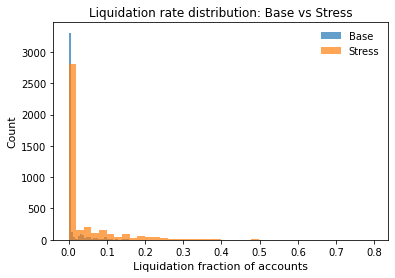

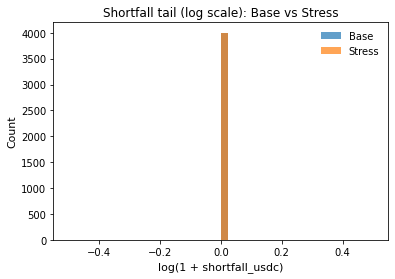

In [10]:
# Diagnostic plots (matplotlib defaults; no explicit colors)
plt.figure()
plt.hist(out_base["liq_rate"], bins=40, alpha=0.7, label="Base")
plt.hist(out_stress["liq_rate"], bins=40, alpha=0.7, label="Stress")
plt.xlabel("Liquidation fraction of accounts")
plt.ylabel("Count")
plt.legend()
plt.title("Liquidation rate distribution: Base vs Stress")
plt.show()

plt.figure()
plt.hist(np.log1p(out_base["shortfall_usdc"]), bins=40, alpha=0.7, label="Base")
plt.hist(np.log1p(out_stress["shortfall_usdc"]), bins=40, alpha=0.7, label="Stress")
plt.xlabel("log(1 + shortfall_usdc)")
plt.ylabel("Count")
plt.legend()
plt.title("Shortfall tail (log scale): Base vs Stress")
plt.show()

### Deterministic shock table 

We run a deterministic shock grid and report liquidation 

In [11]:
shock_grid = np.array([0.0, -0.10, -0.20, -0.30, -0.40, -0.50])
rows = []
for sh in shock_grid:
    p = base_prices["ETH"] * (1.0 + sh)
    rows.append({"ETH_shock": sh, "ETH_price": p, **liquidation_outcomes({"ETH": p, "USDC": 1.0}, depth_eth_usdc=amm_depth)})
shock_table = pd.DataFrame(rows)[["ETH_shock","ETH_price","min_HF","p05_HF","liq_count","liq_rate","exec_slippage","shortfall_usdc"]]
shock_table

,ETH_shock,ETH_price,min_HF,p05_HF,liq_count,liq_rate,exec_slippage,shortfall_usdc
0,0.0000,"2,500.0000",1.1003,1.1708,0,0.0000,0.0000,0.0000
1,-0.1000,"2,250.0000",0.9902,1.0537,3,0.0100,0.0046,0.0000
2,-0.2000,"2,000.0000",0.8802,0.9366,33,0.1100,0.0224,0.0000
3,-0.3000,"1,750.0000",0.7702,0.8195,74,0.2467,0.0462,0.0000
4,-0.4000,"1,500.0000",0.6602,0.7025,133,0.4433,0.0757,0.0000
5,-0.5000,"1,250.0000",0.5501,0.5854,197,0.6567,0.1056,0.0000


The above is a deterministic stress grid showing how the portfolio behaves as ETH declines from 0% to −50%. 
As the shock deepens, the Health Factor distribution shifts downward (`min_HF` and `p05_HF` fall), 
causing a mechanically higher fraction of accounts to cross the liquidation threshold 
(`liq_rate` rises from 0% to 65.7%). 
As liquidation volume increases, execution quality worsens (`exec_slippage` rises to ~10.6%), 
reflecting AMM price impact during forced selling. `shortfall_usdc` remains zero across the grid, 
indicating that under the current haircut/bonus/liquidity-depth assumptions, 
liquidation proceeds are sufficient to cover liabilities even in severe price shocks.

---
The table is a **deterministic sanity-check grid**: we force ETH to specific shock levels (0%, −10%, …, −50%) and recompute:
- `min_HF`, `p05_HF`: how far the weakest accounts fall in solvency terms.
- `liq_rate`, `liq_count`: how many accounts cross the hard liquidation rule ($HF<1$).
- `exec_slippage`: how much worse the realized liquidation execution becomes as we dump more collateral into the AMM.
- `shortfall_usdc`: whether forced selling + liquidation bonus ever fails to cover liabilities.

**What this proves:** as the ETH shock deepens, the outputs move in the expected direction:
- `min_HF` and `p05_HF` fall (accounts become less solvent),
- `liq_rate` rises (more liquidations),
- `exec_slippage` rises (bigger liquidation sales create more price impact),
- `shortfall_usdc` stays 0 here (under the current parameters).

So the model reacts monotonically and mechanically to shocks, before we rely on Monte Carlo distributions.

---

### Single-scenario walkthrough 

The deterministic shock grid (above) shows **how much** liquidation and slippage occur at each shock level, but it does not show **which accounts** drive those outcomes or how the mechanics flow from inputs to results.

This walkthrough picks one representative stress (e.g., an ETH price shock of −30%) and provides an end-to-end audit trail:

$$
\text{prices} \;\rightarrow\; \mathrm{HF}_k^{\text{shock}} \;\rightarrow\; \mathbf{1}\{\mathrm{HF}_k^{\text{shock}}<1\} \;\rightarrow\; \text{liquidation volume} \;\rightarrow\; \text{AMM execution} \;\rightarrow\; \text{bonus/shortfall}.
$$

In other words, we explicitly show (i) how each account’s Health Factor changes under the shock, (ii) which accounts cross the liquidation threshold, and (iii) how those account-level liquidations aggregate into realized execution slippage and (if applicable) shortfall. This makes the results **auditable**: a reviewer can trace every aggregate metric back to specific accounts and assumptions.

This is the same control concept as prime brokerage / margin lending: you need traceability from a market move → margin metric deterioration → liquidation set → realized execution → residual loss.  
The walkthrough makes the liquidation logic reviewable by a risk committee (or an investment committee) before deploying capital.


We report the following for the −30% scenario:
1) account-level $\mathrm{HF}$ changes and the resulting `liquidatable` flags  
2) liquidation aggregates (counts and volumes)  
3) AMM execution realization and implied slippage  
4) liquidation bonus and resulting shortfall (if any)


In [12]:
shock = -0.30
p_eth = base_prices["ETH"] * (1.0 + shock)
prices = {"ETH": p_eth, "USDC": 1.0}

portfolio_explain = portfolio.copy()
portfolio_explain["HF_shock"] = portfolio_explain.apply(lambda r: hf_row(r, prices), axis=1)
portfolio_explain["liquidatable"] = portfolio_explain["HF_shock"] < 1.0

cols_show = ["acct","collateral_ETH","debt_USDC","HF_base","HF_shock","liquidatable"]
sorted_pf = portfolio_explain.sort_values("HF_shock")
head10 = sorted_pf.head(10)[cols_show].reset_index(drop=True)
tail10 = sorted_pf.tail(10)[cols_show].reset_index(drop=True)
head_tail = pd.concat({"Lowest HF (head10)": head10, "Highest HF (tail10)": tail10}, axis=1)
head_tail

Lowest HF (head10)                                                           \
                acct collateral_ETH   debt_USDC HF_base HF_shock liquidatable   
0                222         4.3830  8,465.2327  1.1003   0.7702         True   
1                258         4.9430  9,540.5982  1.1010   0.7707         True   
2                164         6.6541 12,751.1179  1.1089   0.7762         True   
3                128         8.9170 17,015.0206  1.1136   0.7795         True   
4                296        15.0611 28,722.0305  1.1143   0.7800         True   
5                212         7.1372 13,534.1613  1.1206   0.7844         True   
6                155        13.9861 26,498.2006  1.1216   0.7851         True   
7                110         4.2066  7,965.0395  1.1223   0.7856         True   
8                 83         2.8729  5,401.4777  1.1302   0.7912         True   
9                165         9.7456 18,177.7266  1.1393   0.7975         True   

  Highest HF (tail10)                                                           
                 acct collateral_ETH   debt_USDC HF_base HF_shock liquidatable  
0                  31         9.5155  8,269.7997  2.4451   1.7116        False  
1                  90         6.9496  6,039.4806  2.4452   1.7117        False  
2                 106        11.7690 10,205.8891  2.4505   1.7153        False  
3                 130         3.4531  2,986.5561  2.4570   1.7199        False  
4                 129         5.9276  5,092.1306  2.4737   1.7316        False  
5                  10         3.4356  2,951.3067  2.4737   1.7316        False  
6                  68         4.1759  3,578.5107  2.4797   1.7358        False  
7                 101         6.2592  5,351.5216  2.4854   1.7398        False  
8                  19         2.0008  1,708.4763  2.4885   1.7420        False  
9                 259         7.2897  6,222.7276  2.4894   1.7425        False

This table shows **both tails** of the portfolio under the selected scenario (ETH down 30%):
- **Left panel (“Lowest HF”)**: the 10 most vulnerable accounts, i.e., the lowest $\mathrm{HF}_k^{\text{shock}}$. These are the accounts with the lowest post-shock $\mathrm{HF}$. These are the first names to liquidate and therefore drive `liq_rate`. 
- **Right panel (“Highest HF”)**: the 10 safest accounts, i.e., the highest $\mathrm{HF}_k^{\text{shock}}$. These are the accounts with large buffers that remain safe even under the same shock.

Hence, the left panel becomes the actionable watchlist (alerts, top-up requests, exposure caps). The right panel is informational (it explains concentration of safety buffers).

For each account we display:
- `HF_base`: the Health Factor at baseline prices.
- `HF_shock`: the Health Factor after applying the −30% ETH price shock.
- `liquidatable`: `True` when `HF_shock < 1`, meaning the protocol would permit liquidation.

The left-tail accounts were already close to the threshold at baseline (mostly $\mathrm{HF}_{\text{base}}\approx 1.10$–$1.14$). After a −30% ETH shock, their solvency buffers drop to roughly $0.77$–$0.80$, pushing them below 1 and making them liquidatable. By contrast, the right-tail accounts start highly overcollateralized ($\mathrm{HF}_{\text{base}}\approx 2.45$–$2.49$) and remain comfortably safe post-shock ($\mathrm{HF}_{\text{shock}}\approx 1.71$–$1.74$).

---
The accounts flagged `liquidatable=True` above are aggregated into one liquidation “event”.  
The next table rolls up their total debt and collateral, then applies AMM execution to compute realized proceeds, slippage, the liquidation bonus cost, and any residual shortfall.

In [13]:
liq = portfolio_explain["liquidatable"].values
liq_debt = float(portfolio_explain.loc[liq, "debt_USDC"].sum())
liq_coll_eth = float(portfolio_explain.loc[liq, "collateral_ETH"].sum())

exec_res = amm_sell_x_for_y(amm_depth[0], amm_depth[1], dx=liq_coll_eth, fee=0.003)
realized = float(exec_res["dy_out"])
exec_slip = float(max(0.0, 1.0 - exec_res["p_avg"] / exec_res["p_mid_before"]))

bonus_cost = params.liq_bonus * liq_debt
shortfall = max((liq_debt + bonus_cost) - realized, 0.0)

pd.DataFrame([{
    "ETH_shock": shock,
    "ETH_price": p_eth,
    "liq_count": int(liq.sum()),
    "liq_rate": float(liq.mean()),
    "liq_debt_usdc": liq_debt,
    "liq_collateral_eth": liq_coll_eth,
    "AMM_mid_before": exec_res["p_mid_before"],
    "AMM_avg_exec": exec_res["p_avg"],
    "exec_slippage": exec_slip,
    "realized_usdc": realized,
    "liq_bonus": params.liq_bonus,
    "bonus_cost_usdc": bonus_cost,
    "shortfall_usdc": float(shortfall),
}])

,ETH_shock,ETH_price,liq_count,liq_rate,liq_debt_usdc,liq_collateral_eth,AMM_mid_before,AMM_avg_exec,exec_slippage,realized_usdc,liq_bonus,bonus_cost_usdc,shortfall_usdc
0,-0.3000,"1,750.0000",74,0.2467,"770,032.7475",454.6567,"2,500.0000","2,384.4162",0.0462,"1,084,090.6840",0.0500,"38,501.6374",0.0000


This is the **aggregated outcome** for the single −30% ETH shock. It rolls up all accounts with $\mathrm{HF}_k^{\text{shock}}<1$ into a single liquidation “event” and reports the resulting execution and cashflow economics.

- `ETH_shock`, `ETH_price`: the scenario definition (ETH down 30% to 1,750).
- `liq_count`, `liq_rate`: how many accounts become liquidatable and what fraction of the book they represent (74 accounts, 24.67% of the portfolio).
- `liq_debt_usdc`: total debt that must be repaid across all liquidated accounts (770,032.75 USDC).
- `liq_collateral_eth`: total collateral sold from those accounts (454.6567 ETH).

**Execution (AMM) mechanics:**
- `AMM_mid_before`: the pool’s quoted mid price before liquidation selling begins (2,500 USDC/ETH).
- `AMM_avg_exec`: the realized average execution price across the liquidation sale (2,384.42 USDC/ETH).
- `exec_slippage`: the relative execution degradation versus the starting quote:
  $$
  \text{exec_slippage} \approx 1-\frac{\text{AMM_avg_exec}}{\text{AMM_mid_before}}
  $$
  Here it is about 4.62%, reflecting AMM price impact from selling hundreds of ETH into the pool.
- `realized_usdc`: total USDC proceeds from selling the liquidated collateral (1,084,090.68 USDC).

**Liquidation incentive and losses:**
- `liq_bonus`: liquidation incentive rate (5%).
- `bonus_cost_usdc`: the dollar value of the liquidation incentive paid (38,501.64 USDC), computed from the liquidated debt and the bonus rate.
- `shortfall_usdc`: residual loss after proceeds, i.e.,
  $$
  \max\big((\text{liq_debt_usdc}+\text{bonus_cost_usdc})-\text{realized\usdc},\,0\big).
  $$
  It is 0 here, meaning that under the current haircut/bonus/liquidity-depth assumptions, realized sale proceeds are sufficient to cover debt plus the liquidation incentive even in this stressed scenario.

So a −30% ETH move produces a material liquidation wave (24.7% of accounts) and noticeable execution slippage (~4.6%), with no modeled shortfall in this parameterization.

## 7) Margin / top-up sizing (book management action)

If you want to prevent liquidation, you need an actionable control: “How much USDC to repay (or how much ETH to top up) to restore $HF$ to $HF_{\min}$?”

For ETH collateral and USDC debt (single-asset case):

$$HF = \frac{q \cdot P \cdot LT}{D}$$

To restore to $HF_{\min}$ by repaying debt (keeping $q$ fixed):
$$D_{\text{new}} = \frac{q \cdot P \cdot LT}{HF_{\min}}$$
$$\text{Repay} = \max(D - D_{\text{new}}, 0)$$

In [14]:
def repay_to_restore(q_eth: float, D_usdc: float, p_eth: float, LT: float, hf_min: float):
    D_new = (q_eth * p_eth * LT) / hf_min
    repay = max(D_usdc - D_new, 0.0)
    return repay, D_new

hf_min = 1.10
p_eth = base_prices["ETH"] * 0.70  # example stress price (30% drop)
tmp = portfolio.copy()
repays = []
for _, r in tmp.iterrows():
    repay, D_new = repay_to_restore(r["collateral_ETH"], r["debt_USDC"], p_eth, params.LT["ETH"], hf_min)
    repays.append(repay)
tmp["repay_to_HFmin"] = repays

# Show the accounts that require the most repayment to restore buffer
tmp.assign(HF_at_price=tmp.apply(lambda r: hf_row(r, {"ETH": p_eth, "USDC": 1.0}), axis=1))\
   .sort_values("repay_to_HFmin", ascending=False)\
   .head(12)[["acct","collateral_ETH","debt_USDC","HF_base","HF_at_price","repay_to_HFmin"]]

,acct,collateral_ETH,debt_USDC,HF_base,HF_at_price,repay_to_HFmin
296,296,15.0611,"28,722.0305",1.1143,0.7800,"8,355.3303"
155,155,13.9861,"26,498.2006",1.1216,0.7851,"7,585.1396"
271,271,11.5333,"20,652.3268",1.1867,0.8307,"5,056.1677"
165,165,9.7456,"18,177.7266",1.1393,0.7975,"4,999.0663"
128,128,8.9170,"17,015.0206",1.1136,0.7795,"4,956.8212"
162,162,15.2636,"25,471.5335",1.2734,0.8914,"4,830.9751"
74,74,12.3225,"21,385.0681",1.2245,0.8571,"4,721.6513"
212,212,7.1372,"13,534.1613",1.1206,0.7844,"3,882.7757"
164,164,6.6541,"12,751.1179",1.1089,0.7762,"3,752.8941"
81,81,8.5510,"15,003.6156",1.2111,0.8478,"3,440.3192"


This table converts monitoring into an **action plan**. For each account, it calculates how much debt must be repaid **right now** (under the shocked price level) to bring the account back up to an internal safety buffer $\mathrm{HF}_{\min}$ (e.g., 1.10 or 1.20); specifically:
- `HF_base`: the account’s Health Factor at baseline prices.
- `HF_at_price`: the Health Factor after applying the current stressed price scenario (e.g., ETH down 30%); values below 1 indicate liquidation eligibility.
- `repay_to_HFmin`: the **minimum debt repayment** (in USDC) required to raise the account from its current $\mathrm{HF}_{\text{at price}}$ back to $\mathrm{HF}_{\min}$, assuming collateral and prices are unchanged (only debt is reduced).

The table is sorted by `repay_to_HFmin`, so the top rows represent the accounts that require the largest interventions to restore the buffer. For example, account 296 would need to repay about 8,355 USDC to move from $HF_{\text{at price}}\approx 0.78$ back to the policy threshold $HF_{\min}$, while smaller accounts require less. In a way, this is the “margin call / top-up” sizing view used for liquidation prevention and book management.

Mechanically, because $\mathrm{HF} = V_{\text{coll}}/V_{\text{debt}}$, restoring $\mathrm{HF}$ to $\mathrm{HF}_{\min}$ by repayment means reducing debt to $V_{\text{debt}}^{\text{new}} = V_{\text{coll}}/\mathrm{HF}_{\min}$, so `repay_to_HFmin` is the difference between current debt and this target debt level (floored at 0).


## 8) Solidity triage: identify basic security risks / non-standard logic
 
Before deploying capital into a DeFi lending market, you need a *first-pass* smart-contract review to detect non-standard liquidation logic, oracle dependencies, pause/upgrade risks, or admin controls that can change economic outcomes.  

This notebook cannot replace an audit, but it can demonstrate what to look for:

Examples of “red flags”:
- `delegatecall` / upgradeable proxy patterns (admin key risk)
- `tx.origin` authentication
- external calls before state updates (reentrancy risk pattern)
- missing pause/guardian controls
- oracle updates without bounds / stale checks

The checklist is a practical “capital deployment gate” (again not a substitute for a full audit).

Below is a simple text-based scanner that flags these patterns.

In [15]:
solidity_example = r'''
contract Vault {
    address public owner;
    function withdraw(address payable to, uint amount) public {
        require(tx.origin == owner, "not owner");
        (bool ok,) = to.call{value: amount}(""); // external call
        require(ok);
        // state update after external call (reentrancy risk pattern)
    }
    function upgradeTo(address newImpl) external {
        (bool ok,) = newImpl.delegatecall(""); // delegatecall risk
        require(ok);
    }
}
'''

RULES = {
    "tx.origin_auth": "Use of tx.origin for auth (phishing risk)",
    "delegatecall": "delegatecall / upgradeability surface (admin key + upgrade bug risk)",
    "low_level_call": "low-level call (reentrancy surface)",
}

def solidity_triage(src: str):
    flags = []
    s = src.lower()
    if "tx.origin" in s:
        flags.append(("tx.origin_auth", RULES["tx.origin_auth"]))
    if "delegatecall" in s:
        flags.append(("delegatecall", RULES["delegatecall"]))
    if ".call{" in s or ".call(" in s:
        flags.append(("low_level_call", RULES["low_level_call"]))
    return flags

solidity_triage(solidity_example)

[('tx.origin_auth', 'Use of tx.origin for auth (phishing risk)'),
 ('delegatecall',
  'delegatecall / upgradeability surface (admin key + upgrade bug risk)'),
 ('low_level_call', 'low-level call (reentrancy surface)')]

It’s a **pre-deployment control**:
- If the triage flags upgradeability/admin-risk, you demand documentation on governance, timelocks, and emergency pause.
- If reentrancy patterns appear, you require audit evidence or avoid deploying.

## 9) RWA bridge (conceptual): SPV + enforceability + valuation

RWA bridging is typically **legal structure + cashflow**:
- Off-chain asset is held in a bankruptcy-remote SPV.
- Token represents a claim on SPV cashflows (or a secured claim).
- Enforceability depends on jurisdiction, trustee, perfection of security interest, and covenant package.

Valuation (illustrative only):
- expected cashflow $CF_t$
- default probability $p_t$
- discount rate $r$
$$\text{PV}=\sum_t \frac{(1-p_t)CF_t}{(1+r)^t}$$

We compute the PV and a stress PV under higher default.

RWA tokens usually represent a claim on **off-chain cashflows** (invoices, loans, Treasuries via SPVs, etc.).  Even if the token trades on-chain, its economic value is anchored by traditional finance logic: expected cashflows discounted by a risk-adjusted curve.  

The table below is a minimal example showing how a spread/widening stress increases discount rates and mechanically lowers PV.

In [16]:
# RWA cashflow: amortizing cashflows (e.g., invoice/loan pool)
T = 12  # months
CF = np.full(T, 1_000_000.0)  # $1m per month
r_month = 0.01                # 1% monthly discount (toy)
p = np.linspace(0.01, 0.03, T)  # rising default probability (toy)

PV = float(np.sum(((1.0 - p) * CF) / ((1.0 + r_month) ** np.arange(1, T+1))))

# stress: default probabilities higher
p_stress = np.clip(p + 0.05, 0, 0.95)
PV_stress = float(np.sum(((1.0 - p_stress) * CF) / ((1.0 + r_month) ** np.arange(1, T+1))))

pd.DataFrame({
    "month": np.arange(1, T+1),
    "CF": CF,
    "p": p,
    "p_stress": p_stress,
    "disc": (1.0 + r_month) ** np.arange(1, T+1),
    "PV_contrib": ((1.0 - p) * CF) / ((1.0 + r_month) ** np.arange(1, T+1)),
    "PV_contrib_stress": ((1.0 - p_stress) * CF) / ((1.0 + r_month) ** np.arange(1, T+1)),
}), {"PV": PV, "PV_stress": PV_stress, "PV_drop_pct": (PV_stress/PV - 1.0)}

(    month             CF      p  p_stress   disc   PV_contrib  \
 0       1 1,000,000.0000 0.0100    0.0600 1.0100 980,198.0198   
 1       2 1,000,000.0000 0.0118    0.0618 1.0201 968,710.7325   
 2       3 1,000,000.0000 0.0136    0.0636 1.0303 957,354.8277   
 3       4 1,000,000.0000 0.0155    0.0655 1.0406 946,128.8301   
 4       5 1,000,000.0000 0.0173    0.0673 1.0510 935,031.2803   
 5       6 1,000,000.0000 0.0191    0.0691 1.0615 924,060.7353   
 6       7 1,000,000.0000 0.0209    0.0709 1.0721 913,215.7681   
 7       8 1,000,000.0000 0.0227    0.0727 1.0829 902,494.9674   
 8       9 1,000,000.0000 0.0245    0.0745 1.0937 891,896.9376   
 9      10 1,000,000.0000 0.0264    0.0764 1.1046 881,420.2986   
 10     11 1,000,000.0000 0.0282    0.0782 1.1157 871,063.6855   
 11     12 1,000,000.0000 0.0300    0.0800 1.1268 860,825.7485   
 
     PV_contrib_stress  
 0        930,693.0693  
 1        919,695.9300  
 2        908,825.3203  
 3        898,079.8128  
 4        887,4

This is a simple **off-chain cashflow (RWA) valuation** example. We assume a fixed monthly cashflow stream (`CF` = 1,000,000) and compute its present value contribution month-by-month under two default/credit-risk assumptions:

- `p`: baseline monthly default probability (or credit loss rate proxy).
- `p_stress`: stressed monthly default probability (higher credit risk).
- `disc`: the discount factor used to bring month-$t$ cashflows back to today (here increasing over time, so later cashflows are discounted more).
- `PV_contrib`: the present value contribution of that month’s cashflow under baseline credit risk.
- `PV_contrib_stress`: the present value contribution under stressed credit risk.

Under stress, the probability of losing the cashflow is higher (`p_stress > p`), so each month’s risk-adjusted present value is lower. We can see `PV_contrib_stress` is smaller than `PV_contrib` for every month.

The summary underneath aggregates those monthly contributions:
- `PV`: total present value of the 12 cashflows under baseline assumptions (≈ 11.03m).
- `PV_stress`: total present value under stressed credit assumptions (≈ 10.47m).
- `PV_drop_pct`: the percent drop in value under stress (≈ −5.10%).

This illustrates the core RWA bridge idea from a risk perspective: an on-chain token representing off-chain cashflows is ultimately valued by discounting expected cashflows, and stressed credit conditions reduce the valuation via higher default/loss probabilities.
